# Team Travel Insurance

---

Context  <br /> 
A Tour & Travels Company Is Offering Travel Insurance Package To Their Customers.
The New Insurance Package Also Includes Covid Coverage.
The Company Wants To Know Which Customers Would Be Interested In Buying It Based On Its Database History.
The Insurance Was Offered To Some Of The Customers In 2019 And The Given Data Has Been Extracted From The Performance/Sales Of The Package During That Period.
The Data Is Provided For Almost 2000 Of Its Previous Customers.

Focus on:
- Isolating and analyzing the target variable
- Cleaning data
    - Assessing valid types
    - Converting corrupted values
    - Removing invalid data
- Identifying features that have relationships to your target variable and plotting the relationship
- Examining potential outliers and documenting limitations of the dataset
- Deriving information that might predict your target variable
- Articulating the potential value of your findings to a buisness, company, government, or other organization


**Also, we would like to know:**
 - Is this a good source of data?
 - Why / why not?


One of the needs for data science in organizations is to bring measure to vague problems. What can be measured in this dataset with certainty? Drive your presentation from what can be measured, reported. 

Also, if possible, suggest what can be done with this data in terms of actionable outcomes and to what extent.
     

Content
* Age- Age Of The Customer
* Employment Type- The Sector In Which Customer Is Employed
* GraduateOrNot- Whether The Customer Is College Graduate Or Not
* AnnualIncome- The Yearly Income Of The Customer In Indian Rupees[Rounded To Nearest 50 Thousand Rupees]
* FamilyMembers- Number Of Members In Customer's Family
* ChronicDisease- Whether The Customer Suffers From Any Major Disease Or Conditions Like Diabetes/High BP or Asthama,etc.
* FrequentFlyer- Derived Data Based On Customer's History Of Booking Air Tickets On Atleast 4 Different Instances In The Last 2 Years[2017-2019].
* EverTravelledAbroad- Has The Customer Ever Travelled To A Foreign Country[Not Necessarily Using The Company's Services]
* TravelInsurance- Did The Customer Buy Travel Insurance Package During Introductory Offering Held In The Year 2019.


Travel Insurance Prediction Data. Retrieved 10.3.21 from https://www.kaggle.com/tejashvi14/travel-insurance-prediction-data.

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%matplotlib inline



filepath = './data/TravelInsurancePrediction.csv'


In [83]:
ti = pd.read_csv(filepath)
ti.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


## step 1, split the data
**assumes cleaning already completed, dataset already compiled, all observations with target variables**

In [84]:
# split into train and test
train = ti.sample(frac=.9)
mask = ~ti.index.isin(train.index)
test = ti[mask].copy()
print(train.shape[0],test.shape[0])

1788 199


In [85]:
#baseline
train['TravelInsurance'].mean()

0.3540268456375839

## step 2, EDA

In [86]:
# start with the insight that no government sector employees without college degrees purchashed insurance
# it also sees like non-governmental employees buy more insurance...
train.groupby(['Employment Type','GraduateOrNot'])['TravelInsurance'].agg(['mean','count'])

mean  count
Employment Type              GraduateOrNot                 
Government Sector            No             0.000000     38
                             Yes            0.269639    471
Private Sector/Self Employed No             0.400000    235
                             Yes            0.394636   1044

In [87]:
# so I feel like this cohort is resolved and I'm going to look at the remaining people with them split off
mask = (train['Employment Type']=='Government Sector')&(train['GraduateOrNot']=='No')
split_train = train.drop(train[mask].index).copy()

In [88]:
split_train['TravelInsurance'].mean()

0.3617142857142857

In [89]:
# larger families seem to buy more insurance
split_train.groupby(['FamilyMembers'])['TravelInsurance'].agg(['mean','count'])

,mean,count
FamilyMembers,,
2,0.313253,83
3,0.358025,324
4,0.323462,439
5,0.301333,375
6,0.443223,273
7,0.471338,157
8,0.352941,51
9,0.479167,48


In [90]:
# chronic diseases don't seem to factor too much...
split_train.groupby(['ChronicDiseases'])['TravelInsurance'].agg(['mean','count'])

,mean,count
ChronicDiseases,,
0,0.356974,1269
1,0.374220,481


In [91]:
# age is pretty noisy...
split_train.groupby(['Age'])['TravelInsurance'].agg(['mean','count'])

,mean,count
Age,,
25,0.661654,133
26,0.500000,132
27,0.208000,125
28,0.212054,448
29,0.255682,176
30,0.413793,58
31,0.354286,175
32,0.195122,82
33,0.519084,131


In [92]:
# now we're getting somewhere, Frequent Flyers buy at a rate 2x higher
split_train.groupby(['FrequentFlyer'])['TravelInsurance'].agg(['mean','count'])

,mean,count
FrequentFlyer,,
No,0.305294,1379
Yes,0.571429,371


In [93]:
# people who have traveled abroad buy at a rate 3x...
split_train.groupby(['EverTravelledAbroad'])['TravelInsurance'].agg(['mean','count'])


,mean,count
EverTravelledAbroad,,
No,0.262898,1415
Yes,0.779104,335


In [94]:
# if we combine them, we see a further splitting of customers... 
split_train.groupby(['EverTravelledAbroad','FrequentFlyer'])['TravelInsurance'].agg(['mean','count'])

mean  count
EverTravelledAbroad FrequentFlyer                 
No                  No             0.243061   1189
                    Yes            0.367257    226
Yes                 No             0.694737    190
                    Yes            0.889655    145

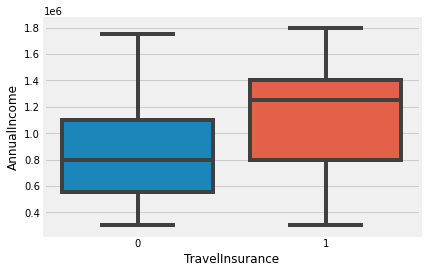

In [95]:
# affluent people definitely buy more insurance, but how should we read this?
sns.boxplot(y=split_train['AnnualIncome'],x=split_train['TravelInsurance']);

In [96]:
def compute_purchase_rate_at_income_thresholds(df,min_pct=80, max_pct=96):
    incomes = []
    # iterate through different percentages of income between 80 and 95 percent
    for i in range(min_pct,max_pct,3):
        income = df['AnnualIncome'].quantile(i*.01)
        if income in incomes:
            continue
        else:
            incomes.append(income)
        mask = df['AnnualIncome']>=income
        print('income above '+str(int(income))+ ' '+str(round(
            df[mask]['TravelInsurance'].mean(),2))+ '% of people bought insurance, '+str(
            df[mask].shape[0])+' in total')
    return

In [97]:
compute_purchase_rate_at_income_thresholds(split_train)

income above 1300000 0.8% of people bought insurance, 389 in total
income above 1350000 0.92% of people bought insurance, 307 in total
income above 1400000 0.91% of people bought insurance, 268 in total
income above 1450000 0.91% of people bought insurance, 154 in total
income above 1500000 0.89% of people bought insurance, 128 in total


In [98]:
#<37% of people bought insurance, but 91% of people with income above 1.35M
# so we create a boolean value to mark income >= 1.35M
split_train['income_thresh'] = split_train['AnnualIncome'].map(
    lambda x: 1 if x>=1350000 else 0)
split_train.sample(3)

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,income_thresh
1072,31,Government Sector,Yes,400000,6,0,No,No,0,0
168,27,Government Sector,Yes,850000,7,1,No,No,0,0
825,29,Private Sector/Self Employed,Yes,900000,7,0,No,No,1,0


In [99]:
# so we combine our three strongest features and we see, that affluent people almost always buy insurance
# except if they have never traveled abroad and are not a frequent flyer
split_train.groupby(['EverTravelledAbroad','FrequentFlyer','income_thresh'])['TravelInsurance'].agg(['mean','count'])

mean  count
EverTravelledAbroad FrequentFlyer income_thresh                 
No                  No            0              0.243220   1180
                                  1              0.222222      9
                    Yes           0              0.234973    183
                                  1              0.930233     43
Yes                 No            0              0.253731     67
                                  1              0.934959    123
                    Yes           0              0.384615     13
                                  1              0.939394    132

In [100]:
# drilling deeper into this group
mask = (split_train['AnnualIncome']>=1350000)&(
    (split_train['EverTravelledAbroad']=='Yes')|(split_train['FrequentFlyer']=='Yes'))
print(split_train[mask].shape)
split_train[mask].groupby(['GraduateOrNot','ChronicDiseases','AnnualIncome'])['TravelInsurance'].agg(['mean','count'])

(298, 10)


mean  count
GraduateOrNot ChronicDiseases AnnualIncome                 
No            0               1350000       1.000000      4
                              1400000       0.666667      3
                              1450000       1.000000      4
                              1550000       1.000000      3
                              1700000       1.000000     12
              1               1350000       0.500000      2
                              1400000       1.000000      3
                              1450000       1.000000      5
                              1550000       1.000000      1
                              1700000       0.000000      3
Yes           0               1350000       1.000000     28
                              1400000       0.934211     76
                              1450000       1.000000     15
                              1500000       0.979592     49
                              1650000       1.000000      1
                              1700000       1.000000     15
                              1750000       0.666667      3
                              1800000       1.000000      1
              1               1350000       0.800000      5
                              1400000       0.875000     32
                              1450000       1.000000      2
                              1500000       0.954545     22
                              1650000       1.000000      1
                              1700000       1.000000      4
                              1750000       0.000000      1
                              1800000       1.000000      3

In [101]:
# so we pull these people out and continue our analysis of the remaining people
mask = (split_train['AnnualIncome']>=1350000)&(
    (split_train['EverTravelledAbroad']=='Yes')|(split_train['FrequentFlyer']=='Yes'))&(
    (split_train['ChronicDiseases']==0)|(split_train['AnnualIncome']<1700000)|(split_train['GraduateOrNot']=='Yes'))
print(split_train[mask].shape[0])
split_train.drop(split_train[mask].index,inplace=True)

295


In [102]:
split_train['TravelInsurance'].mean()

0.24329896907216494

In [103]:
# just as high income was different, really low income is different
mask = split_train['AnnualIncome']<=split_train['AnnualIncome'].quantile(.07)
print(split_train['AnnualIncome'].quantile(.07))
print(split_train[mask].shape[0])
split_train[mask]['TravelInsurance'].mean()

350000.0
103


0.0970873786407767

In [104]:
# the next tranche of income buys at average rates
mask = (split_train['AnnualIncome']>=split_train['AnnualIncome'].quantile(.08))&(
    split_train['AnnualIncome']<=split_train['AnnualIncome'].quantile(.12))
print(split_train[mask].shape[0])
split_train[mask]['TravelInsurance'].mean()

190


0.23157894736842105

In [105]:
#income thresh and not a graduate and (under 33 or private sector
mask = (split_train['AnnualIncome']<=400000)#&(split_train['GraduateOrNot']=='Yes')&((
  #  split_train['Age']<33)|(split_train['Employment Type']=='Government Sector'))
split_train[mask].groupby(['Age'])['TravelInsurance'].agg(['mean','count'])

,mean,count
Age,,
27,0.000000,9
28,0.103448,58
29,0.200000,10
31,0.040000,25
32,0.076923,26
33,0.363636,22


In [106]:
# so let's pull out the least affluent people
mask = (split_train['AnnualIncome']<=400000)&(split_train['Age']<33)
split_train.drop(split_train[mask].index,inplace=True)

In [107]:
split_train['TravelInsurance'].mean()

0.2584777694046722

In [108]:
# this no longer as meaningful after you account for high income
split_train.groupby(['EverTravelledAbroad','FrequentFlyer'])['TravelInsurance'].agg(['mean','count'])

mean  count
EverTravelledAbroad FrequentFlyer                 
No                  No             0.262218   1064
                    Yes            0.232432    185
Yes                 No             0.250000     64
                    Yes            0.357143     14

In [109]:
# but we can see how other features still split the data
split_train.groupby(['GraduateOrNot'])['TravelInsurance'].agg(['mean','count'])

,mean,count
GraduateOrNot,,
No,0.312169,189
Yes,0.249561,1138


In [110]:
# affluence still matters
print(split_train['TravelInsurance'].mean())
compute_purchase_rate_at_income_thresholds(split_train)

0.2584777694046722
income above 1150000 0.24% of people bought insurance, 330 in total
income above 1200000 0.25% of people bought insurance, 259 in total
income above 1250000 0.28% of people bought insurance, 161 in total
income above 1300000 0.36% of people bought insurance, 94 in total


In [111]:
# now that we've accounted for wealthy people, age seems to matter quite a bit, 
# with older people more likely to buy insurance
split_train.groupby(['Age'])['TravelInsurance'].agg(['mean','count'])

,mean,count
Age,,
25,0.250000,56
26,0.166667,78
27,0.196429,112
28,0.189702,369
29,0.212903,155
30,0.306122,49
31,0.166667,102
32,0.250000,56
33,0.419048,105


In [112]:
# but we can try combining age with other variables to look for interactions, and look what we find... 
# not merely older people, but specifically older people with large families buy insurance at high rates
split_train['age_thresh'] = split_train['Age'].map(lambda x: 1 if x>=33 else 0)
split_train.groupby(['age_thresh','FamilyMembers'])['TravelInsurance'].agg(['mean','count'])

mean  count
age_thresh FamilyMembers                 
0          2              0.272727     44
           3              0.223464    179
           4              0.192913    254
           5              0.181373    204
           6              0.190476    147
           7              0.236559     93
           8              0.064516     31
           9              0.320000     25
1          2              0.000000     19
           3              0.226415     53
           4              0.268817     93
           5              0.200000     80
           6              0.867925     53
           7              0.937500     32
           8              0.909091     11
           9              0.666667      9

In [113]:
# so we pull these people out
mask = (split_train['Age']>=33)&(split_train['FamilyMembers']>=6)
split_train[mask].groupby(['AnnualIncome'])['TravelInsurance'].agg(['mean','count'])

,mean,count
AnnualIncome,,
400000,0.875000,8
500000,0.600000,5
550000,0.666667,3
600000,0.666667,3
650000,1.000000,1
700000,0.923077,13
750000,1.000000,2
800000,1.000000,14
900000,0.666667,3


In [114]:
# so we pull these people out
mask = (split_train['Age']>=33)&(split_train['FamilyMembers']>=6)
split_train.drop(split_train[mask].index,inplace=True)

In [115]:
# flying experience + government 2-3x as likely as remaining people
split_train.groupby(['EverTravelledAbroad','FrequentFlyer','Employment Type'])['TravelInsurance'].agg(['mean','count'])

mean  \
EverTravelledAbroad FrequentFlyer Employment Type                          
No                  No            Government Sector             0.208661   
                                  Private Sector/Self Employed  0.208276   
                    Yes           Government Sector             0.315789   
                                  Private Sector/Self Employed  0.155556   
Yes                 No            Government Sector             0.312500   
                                  Private Sector/Self Employed  0.142857   
                    Yes           Government Sector             0.500000   
                                  Private Sector/Self Employed  0.125000   

                                                                count  
EverTravelledAbroad FrequentFlyer Employment Type                      
No                  No            Government Sector               254  
                                  Private Sector/Self Employed    725  
                    Yes           Government Sector                38  
                                  Private Sector/Self Employed    135  
Yes                 No            Government Sector                16  
                                  Private Sector/Self Employed     42  
                    Yes           Government Sector                 4  
                                  Private Sector/Self Employed      8

In [116]:
# so remove these people
mask = (split_train['Employment Type']=='Government Sector')&(
    (split_train['EverTravelledAbroad']=='Yes')|(split_train['FrequentFlyer']=='Yes'))
split_train.drop(split_train[mask].index,inplace=True)

In [117]:
# private sector graduates with flying experiences particularly unlikely to buy
split_train.groupby(['EverTravelledAbroad','FrequentFlyer','Employment Type'
                    ,'GraduateOrNot'])['TravelInsurance'].agg(['mean','count'])

mean  \
EverTravelledAbroad FrequentFlyer Employment Type              GraduateOrNot             
No                  No            Government Sector            Yes            0.208661   
                                  Private Sector/Self Employed No             0.271318   
                                                               Yes            0.194631   
                    Yes           Private Sector/Self Employed No             0.225806   
                                                               Yes            0.134615   
Yes                 No            Private Sector/Self Employed No             0.250000   
                                                               Yes            0.117647   
                    Yes           Private Sector/Self Employed No             0.000000   
                                                               Yes            0.250000   

                                                                              count  
EverTravelledAbroad FrequentFlyer Employment Type              GraduateOrNot         
No                  No            Government Sector            Yes              254  
                                  Private Sector/Self Employed No               129  
                                                               Yes              596  
                    Yes           Private Sector/Self Employed No                31  
                                                               Yes              104  
Yes                 No            Private Sector/Self Employed No                 8  
                                                               Yes               34  
                    Yes           Private Sector/Self Employed No                 4  
                                                               Yes                4

In [118]:
# so we drop them
mask = (split_train['Employment Type']=='Private Sector/Self Employed')&(
    (split_train['EverTravelledAbroad']=='Yes')|(split_train['FrequentFlyer']=='Yes'))&(
    split_train['GraduateOrNot']=='Yes')
split_train.drop(split_train[mask].index,inplace=True)

In [119]:
# non graduates seem to buy at a bit higher rate
print(split_train.TravelInsurance.mean())
mask = (split_train['GraduateOrNot']=='No')&(split_train['Age']>=28)
split_train[mask].groupby(['Employment Type'])['TravelInsurance'].agg(['mean','count'])

0.20841487279843443


,mean,count
Employment Type,,
Private Sector/Self Employed,0.291262,103


In [120]:
mask = (split_train['GraduateOrNot']=='No')&(split_train['Age']>=28)
split_train.drop(split_train[mask].index,inplace=True)

In [121]:
# new baseline is 20%
split_train['TravelInsurance'].mean()

0.19912948857453755

In [122]:
# there is some more information here that we could mine, and it would help, but it seems marginal

# income seems to matter a bit
split_train['income_thresh'] = split_train['AnnualIncome'].map(lambda x: 1 if x>=1300000 else 0)
split_train.groupby(['income_thresh'])['TravelInsurance'].agg(['mean','count'])

,mean,count
income_thresh,,
0,0.200000,860
1,0.186441,59


In [123]:
# chronic disases matter a bit..
split_train.groupby(['ChronicDiseases'])['TravelInsurance'].agg(['mean','count'])

,mean,count
ChronicDiseases,,
0,0.189602,654
1,0.222642,265


In [124]:
split_train.groupby(['GraduateOrNot'])['TravelInsurance'].agg(['mean','count'])

,mean,count
GraduateOrNot,,
No,0.202899,69
Yes,0.198824,850


In [125]:
# could be fluky but larger familes still seem to matter
split_train.groupby(['FamilyMembers'])['TravelInsurance'].agg(['mean','count'])

,mean,count
FamilyMembers,,
2,0.239130,46
3,0.207865,178
4,0.206767,266
5,0.170732,205
6,0.196262,107
7,0.219178,73
8,0.083333,24
9,0.300000,20


## step 3, compile train and test

In [126]:
# but let's just use the features we derived

def add_feature_column(df, col, mask):
    df.loc[df[mask].index,col]=1
    df[col].fillna(0,inplace=True)
    return df
    

def add_features_for_training(df):

    # affluence + experience traveling
    mask = (df['AnnualIncome']>=1350000)&(
        (df['EverTravelledAbroad']=='Yes')|(df['FrequentFlyer']=='Yes'))&(
    (df['ChronicDiseases']==0)|(df['AnnualIncome']<1700000)|(df['GraduateOrNot']=='Yes'))
    df = add_feature_column(df, col='high_inc_travel_exp',mask=mask)
   
    # 5% percentile income
    mask = (df['AnnualIncome']<=400000)&(df['Age']<33)
    df = add_feature_column(df, col='low_inc',mask=mask)
    
    # govt job + travel
    mask = (df['Employment Type']=='Government Sector')&(
        (df['EverTravelledAbroad']=='Yes')|(df['FrequentFlyer']=='Yes'))
    df = add_feature_column(df, col='gov_abroad_or_flyer',mask=mask)
    
    # non govt job + travel
    mask = (df['Employment Type']=='Private Sector/Self Employed')&(
        (df['EverTravelledAbroad']=='Yes')|(df['FrequentFlyer']=='Yes'))&(
        df['GraduateOrNot']=='Yes')
    df = add_feature_column(df, col='corp_abroad_or_flyer',mask=mask)

    # goverment workers without a degree
    mask = (df['Employment Type']=='Government Sector')&(df['GraduateOrNot']=='No')
    df = add_feature_column(df, col='gov_no_deg',mask=mask)

    # older people with large families
    mask = (df['Age']>=33)&(df['FamilyMembers']>=6)
    df = add_feature_column(df, col='lg_fam_older',mask=mask)
    
    # more mature non college
    mask = (df['GraduateOrNot']=='No')&(df['Age']>=28)
    df = add_feature_column(df, col='mature_non_college',mask=mask)
    
    # max family
    mask = (df['FamilyMembers']==9)
    df = add_feature_column(df, col='max_family_size',mask=mask)
    
    return df


In [4]:
train = add_features_for_training(train)
test = add_features_for_training(test)

NameError: name 'add_features_for_training' is not defined

In [5]:
# pull out our features 
train_features = ['high_inc_travel_exp','lg_fam_older',
                  'low_inc', 'gov_abroad_or_flyer', 'corp_abroad_or_flyer', 'gov_no_deg',
                    'mature_non_college', 'max_family_size']
X_train = train[train_features].copy()
X_test = test[train_features].copy()
# identical features in test data
y_train = train['TravelInsurance']
y_test = test['TravelInsurance']

NameError: name 'train' is not defined

## step 4, cross validation

In [135]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

logr = LogisticRegression()
# we pass in our estimator, how many features to drop at each interval, how many folds
selector_brier = RFECV(logr, step=1, cv=10, verbose=False,scoring='neg_brier_score')
selector_acc = RFECV(logr, step=1, cv=10, verbose=False,scoring='accuracy')
# we fit the selector to obtain the columns that work best with our estimator
selector_brier.fit(X_train, y_train)
selector_acc.fit(X_train, y_train)
# selector support is a boolean mask we are using to slice our column list
print(X_train.columns)
print(selector_brier.support_)
rfecv_columns = X_train.columns[selector_brier.support_]
print(rfecv_columns)

Index(['high_inc_travel_exp', 'lg_fam_older', 'low_inc', 'gov_abroad_or_flyer',
       'corp_abroad_or_flyer', 'gov_no_deg', 'mature_non_college',
       'max_family_size'],
      dtype='object')
[ True  True  True  True  True  True  True  True]
Index(['high_inc_travel_exp', 'lg_fam_older', 'low_inc', 'gov_abroad_or_flyer',
       'corp_abroad_or_flyer', 'gov_no_deg', 'mature_non_college',
       'max_family_size'],
      dtype='object')


In [134]:
# note the difference using accuracy as a scoring criteria, only 2 columns matter
print(X_train.columns)
print(selector_acc.support_)
X_train.columns[selector_acc.support_]


Index(['high_inc_travel_exp', 'lg_fam_older', 'low_inc', 'gov_abroad_or_flyer',
       'corp_abroad_or_flyer', 'gov_no_deg', 'mature_non_college',
       'max_family_size'],
      dtype='object')
[ True  True False False False False False False]


Index(['high_inc_travel_exp', 'lg_fam_older'], dtype='object')

In [160]:
rfc_params = {
    'max_depth':[None],
    'min_samples_split':[16,20,24],
    'min_impurity_decrease':[.0,.0001,.0002]}

# we pass in our estimator, our dictionary of parameters, and the number of folds
rfc_gs = GridSearchCV(RandomForestClassifier(n_estimators=100), rfc_params, cv=5,
                      verbose=1,scoring='neg_brier_score')
# we fit the grid search object
rfc_gs.fit(X_train[rfecv_columns], y_train)
# once fit, we can access our models best parameters as well as other attributes
print(rfc_gs.best_score_)
rfc_gs.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
-0.1330277463405838


{'max_depth': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 16}

In [150]:
scores = cross_validate(logr, X_train[rfecv_columns], y_train,cv=5,scoring='neg_brier_score')
print(scores['test_score'].mean())

-0.13280424351861198


# step 5, fit on train, score and predict on test

In [156]:
# instantiate
logr = LogisticRegression()
# fit on training data, happens inplace
logr.fit(X_train,y_train)

LogisticRegression()

In [158]:
X_test['preds'] = logr.predict_proba(X_test)[:,1:]
brier_score_loss(y_test,X_test.preds)

0.12246596793729612

In [159]:
# we can pull out out our preds and look at them
# what did the model seem to do that we couldn't have accomplished just using some averages instead?
X_test.drop_duplicates(subset=train_features).sort_values('preds',ascending=False)

,high_inc_travel_exp,lg_fam_older,low_inc,gov_abroad_or_flyer,corp_abroad_or_flyer,gov_no_deg,mature_non_college,max_family_size,preds
631,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.995582
64,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.961980
1754,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.955298
1855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.936123
49,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.922070
884,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.895668
1292,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.851877
176,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.829278
1219,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.796822
1024,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.347998
